# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import datetime
import pytz
import random

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import torchvision.models as models
from torchvision.models import resnet34, ResNet34_Weights
from torchvision import models

In [ ]:
import torch
from PIL import Image
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset,random_split
from skimage import io, transform
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
tzInfo = pytz.timezone('Asia/Kolkata')
dt = str(datetime.datetime.now(tz=tzInfo))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Paths

In [ ]:
result_PATH = "/content/drive/MyDrive/Drive f20190077/4-2/0_Split/results_clients.csv"
csv_PATH = "/content/drive/MyDrive/Drive f20190077/4-2/0_Split/DR/trainLabels_Binary.csv"
class_PATH = "/content/drive/MyDrive/Drive f20190077/4-2/0_Split/DR/resized_train_cropped/Classes2/"
images_PATH = "/content/drive/MyDrive/Drive f20190077/4-2/0_Split/DR/resized_train_cropped/resized_train_cropped/"
model_PATH = '/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/' 

## Constants

In [ ]:
results = {"Clients":[],	"Train_Images": [],	"Test_Images":[],	"Epochs":[],
        "Test_Accuracy":[], "Train_Time":[],	"Test_Time":[], "Datetime":[]}

results

{'Clients': [],
 'Train_Images': [],
 'Test_Images': [],
 'Epochs': [],
 'Test_Accuracy': [],
 'Train_Time': [],
 'Test_Time': [],
 'Datetime': []}

In [ ]:
num_clients = 3
cut_layer = 3 # DO NOT USE CUT_LAYER = 1, IT GIVES A "Lead Variable can't be used for in-place operation" ERROR (at the line outputs =  server_model(server_inputs))
train_images = 1000
test_images = int(train_images/5)
epochs = 20
learning_rate = 0.001

In [ ]:
print(train_images)

1000


## Transforms

In [ ]:
import torchvision.transforms as transforms

c_trans = transforms.Compose([ # For ImageFolder
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])


d_trans = transforms.Compose([ # For the dataset class
    transforms.ToPILImage(), ## WE NEED THIS OR ELSE IT GIVES TYPE ERROR WITH NUMPY NDARRAY
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load Data, Normalize, Trainloader

## DF Split!

In [ ]:
cropped_new_df = pd.read_csv(csv_PATH)
cropped_new_df.head()

,Unnamed: 0,image,level
0,0,10_left,0
1,1,10_right,0
2,2,13_left,0
3,3,13_right,0
4,5,15_right,1


In [ ]:
len(cropped_new_df)

32670

In [ ]:
cdf = cropped_new_df.copy()

In [ ]:
len(cdf)

32670

### Old

In [ ]:
cdf = cropped_new_df.copy()
y = cdf.pop('level').to_frame()
X = cdf

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.4) # Stratify = y, maintains the same proportion of zero:one as the original in the new sets too!

In [ ]:
len(X_train)

19602

In [ ]:
def count_nums(df):
  lis = [l for l in df["level"]]
  print("Total = ", len(lis))
  z, o = lis.count(0), lis.count(1)
  print(z, " zeroes and ", o, " ones")
  print("Zero : One Ratio is ", round(z/o, 4))
  print()

In [ ]:
X["level"] = y["level"]
X_train["level"] = y_train["level"]
X_test["level"] = y_test["level"]

count_nums(X)
count_nums(X_train)
count_nums(X_test) # Stratify = y, maintains the same proportion of zero:one as the original in the new sets too!

Total =  32670
25802  zeroes and  6868  ones
Zero : One Ratio is  3.7568

Total =  19602
15481  zeroes and  4121  ones
Zero : One Ratio is  3.7566

Total =  13068
10321  zeroes and  2747  ones
Zero : One Ratio is  3.7572



## Dataset class!

In [ ]:
class retinaDataset_New(Dataset):
    def __init__(self, imagepath = images_PATH, cdf_trest = None, transform = None):
        self.df = cropped_new_df
        
        if (cdf_trest is not None):
            self.df = cdf_trest
        
        self.transform = transform
        
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        # img = Image.open(img_path) # Old
        img = io.imread(img_path) # New
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        if(self.transform):
            img = self.transform(img)
        
        return img, torch.tensor(self.df.iloc[index].level)

## Separate Datasets for each Client

In [ ]:
def train_split_equal_binary(cdf, samples_n_train, samples_n_test): #samples_n per class

    see = random.randint(1, 18)
    # print(see)
    
    X_train, X_i, y_i = make_df(cdf, samples_n_train, see)

    # Remove the X_train elements from the overall list
    [X_i.remove(v) for v in X_train["image"]]
    [y_i.remove(w) for w in X_train["level"]]

    # This is so we can reshuffle the X_i and y_i after removing the 'X_train' elements
    cdf = pd.DataFrame()
    cdf["image"] = X_i
    cdf["level"] = y_i

    # print("After Train Set item removal")
    # print(" ",len(X_i), len(y_i))

    X_test, X_i, y_i = make_df(cdf, samples_n_test, see)


    return X_train, X_test, cdf # Returns DFs


def make_df(cdf, samples_n, seed): # Given the cropped df, shuffle it and make a df with equal zeroes and ones!
    indicesClass1 = []
    indicesClass2 = []

    cdf.sample(frac=1, random_state=seed)

    y_i = [x for x in cdf["level"]]
    X_i = [x for x in cdf["image"]]

    # print("Inside mdf")
    # print(" ",len(X_i), len(y_i))

    # Get Equal Zeros and Ones in X_indices
    for i in range(0, len(y_i)):
        if y_i[i] == 0 and len(indicesClass1) < samples_n:
            indicesClass1.append((X_i[i], y_i[i]))
        elif y_i[i] == 1 and len(indicesClass2) < samples_n:
            indicesClass2.append((X_i[i], y_i[i]))
            
        if len(indicesClass1) == samples_n and len(indicesClass2) == samples_n:
            break
    
    X_indices = indicesClass1 + indicesClass2
    X_trest = pd.DataFrame({"image":[], "level":[]})

    # Make it a df!
    X_trest["image"] = [a for a, b in X_indices]
    X_trest["level"] = [b for a, b in X_indices]

    return X_trest, X_i, y_i

In [ ]:
def create_test_train_loaders(cdf, train_images = train_images, test_images = test_images, batch_size = 32):

  cdf_train, cdf_test, cdf = train_split_equal_binary(cdf, samples_n_train = int(train_images/2), samples_n_test = int(test_images/2))
  # print(len(cdf))
  # cdf_train_2, cdf_test_2, cdf = train_split_equal_binary(cdf, samples_n_train = int(train_images/2), samples_n_test = int(test_images/2))

  cdf_TR = cdf_train.copy() # Change this for testset too!
  class_counts = cdf_TR.level.value_counts()
  class_weights = 1/class_counts
  train_weights = [1/class_counts[i] for i in cdf_TR.level.values] # Need weights for each image!!! Sampler is class agnostic, operates on the image level!!

  cdf_TS = cdf_test.copy() # Change this for testset too!
  class_counts = cdf_TS.level.value_counts()
  class_weights = 1/class_counts
  test_weights = [1/class_counts[i] for i in cdf_TS.level.values] # Need weights for each image!!! Sampler is class agnostic, operates on the image level!!

  train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, num_samples = train_images, replacement = True) # This just makes sure that each batch has equal 0s and 1s
  test_sampler = torch.utils.data.sampler.WeightedRandomSampler(test_weights, num_samples = test_images, replacement = True) # It does NOT balance the dataset!!

  trainset_DS = retinaDataset_New(cdf_trest = cdf_train, transform = d_trans)
  testset_DS = retinaDataset_New(cdf_trest = cdf_test, transform = d_trans) # Helps ensure that batches are also balanced!! (Dataset is already balanced by our previous functions!!)

  trainloader_DS = DataLoader(dataset=trainset_DS, batch_size = 32, sampler = train_sampler)
  testloader_DS = DataLoader(dataset=testset_DS, batch_size = 32, sampler = test_sampler)

  return cdf, cdf_train, cdf_test, trainloader_DS, testloader_DS

## Train and Testloaders

In [ ]:
print(num_clients)

3


In [ ]:
cdf = cropped_new_df.copy()

cdf_train_list = []
cdf_test_list = []

trainloaders = [[] for _ in range(num_clients)]
testloaders = [[] for _ in range(num_clients)]

for c in range(num_clients):
  cdf, cdf_train, cdf_test, trainloader_DS, testloader_DS = create_test_train_loaders(cdf, train_images = train_images, test_images = test_images, batch_size = 32)

  trainloaders[c] = trainloader_DS
  testloaders[c] = testloader_DS

  cdf_train_list.append(cdf_train)
  cdf_test_list.append(cdf_test)


In [ ]:
print(cdf_train_list[0].head(20))

       image  level
0    10_left      0
1   10_right      0
2    13_left      0
3   13_right      0
4    17_left      0
5    19_left      0
6   19_right      0
7    20_left      0
8   20_right      0
9    21_left      0
10  21_right      0
11   22_left      0
12  22_right      0
13   23_left      0
14  23_right      0
15   25_left      0
16  25_right      0
17   31_left      0
18  31_right      0
19   33_left      0


In [ ]:
# print(cdf_train_list[1].head(20))

In [ ]:
# count_nums(cdf_train_list[0])
# count_nums(cdf_train_list[1])

# count_nums(cdf_test_list[0])
# count_nums(cdf_test_list[1])

# Client and Server classes


In [ ]:
class Client(nn.Module): # M
  def __init__(self, config):
    super().__init__()
    self.cut_layer = config["cut_layer"]

    self.model = resnet34(weights = None)

    self.model = nn.ModuleList(self.model.children())
    self.model = nn.Sequential(*self.model)



  def forward(self, x):
    for i, layer in enumerate(self.model):
      if i > self.cut_layer:
        break
      else:
        x = layer(x)

    return x

In [ ]:
class Server(nn.Module): # M
  def __init__(self, config):
    super().__init__()
    self.logits = config["logits"]
    self.cut_layer = config["cut_layer"]

    self.model = resnet34(weights = None)

    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Sequential(nn.Flatten(), nn.Linear(num_ftrs, self.logits))


    self.model = nn.ModuleList(self.model.children()) # These 2 lines help us iterate over the layers (blocks)
    self.model = nn.Sequential(*self.model)


  def forward(self, x):
    for i, layer in enumerate(self.model):
      if i <= self.cut_layer:
        continue
      else:
        x = layer(x)
    m = nn.Softmax(dim = 1)

    return m(x)

In [ ]:
config = {"cut_layer":cut_layer, "logits":2}
print("Cut layer: ", cut_layer)
client_model = Client(config).to(device) # M
server_model = Server(config).to(device) # M

Cut layer:  3


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
pytorch_total_params_c = sum(p.numel() for p in client_model.parameters())
print("Total parameters Client ", pytorch_total_params_c)

print()

pytorch_total_params_s = sum(p.numel() for p in server_model.parameters())
print("Total parameters Server ", pytorch_total_params_s)

Total parameters Client  21797672

Total parameters Server  21285698


In [ ]:
criterion = nn.CrossEntropyLoss() # C
client_optimizer = optim.Adam(client_model.parameters(), lr = 1e-2) # O (Change to Adam)
server_optimizer = optim.Adam(server_model.parameters(), lr = 1e-2) # O

In [ ]:
print(device)

cuda


In [ ]:
def test_accuracy(model_PATH, testloader_DS, testloader_IF = None, mode = "DS"):
  tic = time.time()

  client_model = Client(config).to(device) # M
  server_model = Server(config).to(device) # M

  client_model.load_state_dict(torch.load(model_PATH+"Client.pth"))
  server_model.load_state_dict(torch.load(model_PATH+"Server.pth"))

  client_model.eval()
  server_model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data in testloader_DS:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = server_model(client_model(images))

      _, predicted = torch.max(outputs, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  toc = time.time()
  t_test = toc - tic
  acc = 100*correct/total

  print(total)


  print("Accuracy of the model is- ", acc, "%")
  return acc, t_test

# acc, t_test = test_accuracy(model_PATH, testloader_DS, testloader_IF = None, mode = "DS")

## Log

In [ ]:
def update_results(result_PATH, d_new):
  df = pd.read_csv(result_PATH, index_col=0)

  d_existing = df.to_dict('list')
  print(d_existing)
  print()
  # print(list(d_existing.keys()))
  # print(d_existing)

  for key in list(d_existing.keys()):
    d_existing[key] = d_existing[key] + d_new[key]

  ndf = pd.DataFrame(d_existing)
  ndf.to_csv(result_PATH)

  print("DONE!")
  print()

  return d_existing

def del_last_update(result_PATH, last_n = 1): # last_n = 2 => Delete last 2 entries
  df = pd.read_csv(result_PATH, index_col=0)
  dic = df.to_dict('list')

  for key in list(dic.keys()):

    lis = dic[key]
    if lis == []:
      continue
    dic[key] = lis[:len(lis)-last_n]

  ndf = pd.DataFrame(dic)
  ndf.to_csv(result_PATH)

  print("DONE!")

  return dic

# N Clients + Server - MCOZ PLBS

In [ ]:
total_clients = num_clients
print(total_clients, " Clients!")

client_model_list = [Client(config).to(device) for _ in range(total_clients)] # M
server_model = Server(config).to(device) # M

3  Clients!


In [ ]:
criterion = nn.CrossEntropyLoss() # C 
client_optimizer_list = [optim.SGD(client_model_list[i].parameters(), lr = 1e-2, momentum = 0.9) for i in range(total_clients)] # O
server_optimizer = optim.SGD(server_model.parameters(), lr = 1e-2, momentum = 0.9) # O

## Training Loop

In [ ]:
epoch_losses = [[] for _ in range(num_clients)]

def training_loop_multiple(client_model_list, server_model, epochs, trainloaders):
  tic = time.time()

  num_epochs = epochs

  for epoch in range(num_epochs):
    print("EPOCH ", epoch+1)

    for c in range(num_clients):
      print(" Current active client is {}".format(c))
      # loader = trainloaders[c] # Trying different Trainloaders for each client => Significant loss in accuracy
      loader = trainloaders[0] # Trying to use the same trainloaders and different testloaders
      client = client_model_list[c]
      client_optimizer = client_optimizer_list[c]


      if c == 0:
        if epoch != 0:
          prev_client = total_clients - 1
          prev_client_weights = client_model_list[prev_client].state_dict()
          client.load_state_dict(prev_client_weights)
          print(" Loaded client {}'s weight successfully".format(prev_client))
      else:
        prev_client = c - 1
        prev_client_weights = client_model_list[prev_client].state_dict()
        client.load_state_dict(prev_client_weights)
        print(" Loaded client {}'s weight successfully".format(prev_client))

      client.train()
      running_loss = 0.0
      total_samples = 0
      for i, data in enumerate(loader, 0):
        # print(i)
        inputs, labels = data[0].to(device), data[1].to(device)

        client_optimizer.zero_grad() # Z
        server_optimizer.zero_grad() # Z

        activations = client(inputs) # P
        server_inputs = activations.detach().clone()
        server_inputs = Variable(server_inputs, requires_grad = True)
        outputs = server_model(server_inputs) # P

        loss = criterion(outputs, labels) # L
        loss.backward() # B

        server_optimizer.step() # S
        activations.backward(server_inputs.grad) # B
        client_optimizer.step()

        running_loss += loss.item()
        total_samples += labels.shape[0]

        # if i % 30 == 29:
        #   print('   Client: {} Epoch: {}, Iteration: {}, Loss: {:.4f}'.format(c, epoch+1, i+1, running_loss/(i+1)))

          
      epoch_loss = running_loss / len(loader)
      print(" EPOCH: ", epoch + 1, "CLIENT: ",str(c),  " LOSS: ", round(epoch_loss, 4))
      epoch_losses[c].append(epoch_loss)
        
      print()
    print("______________________________________________________________________")

  toc = time.time()
  t_train = toc-tic
  print("DONE!!")

  return client_model_list, server_model, t_train

epochs = epochs
print("Starting training for: ", epochs, " epochs")
client_model_list, server_model, t_train = training_loop_multiple(client_model_list, server_model, epochs, trainloaders)

Starting training for:  20  epochs
EPOCH  1
 Current active client is 0
 EPOCH:  1 CLIENT:  0  LOSS:  0.7172

 Current active client is 1
 Loaded client 0's weight successfully
 EPOCH:  1 CLIENT:  1  LOSS:  0.7201

 Current active client is 2
 Loaded client 1's weight successfully
 EPOCH:  1 CLIENT:  2  LOSS:  0.7125

______________________________________________________________________
EPOCH  2
 Current active client is 0
 Loaded client 2's weight successfully
 EPOCH:  2 CLIENT:  0  LOSS:  0.6956

 Current active client is 1
 Loaded client 0's weight successfully
 EPOCH:  2 CLIENT:  1  LOSS:  0.7046

 Current active client is 2
 Loaded client 1's weight successfully
 EPOCH:  2 CLIENT:  2  LOSS:  0.6737

______________________________________________________________________
EPOCH  3
 Current active client is 0
 Loaded client 2's weight successfully
 EPOCH:  3 CLIENT:  0  LOSS:  0.6707

 Current active client is 1
 Loaded client 0's weight successfully
 EPOCH:  3 CLIENT:  1  LOSS:  0.6

In [ ]:
# new_epoch_losses = [[0.7235971577465534,
#   0.7672127019613981,
#   0.7019465621560812,
#   0.7205630168318748,
#   0.7115420140326023,
#   0.6803107652813196,
#   0.6787140890955925,
#   0.6792220920324326,
#   0.6923900097608566,
#   0.6985050272196531,
#   0.6993332114070654,
#   0.6870204154402018,
#   0.6675914395600557,
#   0.6965758800506592,
#   0.6809184588491917,
#   0.6935798283666372,
#   0.6643086653202772,
#   0.683568712323904,
#   0.6787238791584969,
#   0.6905483957380056],
#  [0.721476698294282,
#   0.7095981147140265,
#   0.7052450403571129,
#   0.7013949640095234,
#   0.683035908266902,
#   0.6980467066168785,
#   0.6732277926057577,
#   0.697983993217349,
#   0.6864100396633148,
#   0.7075986415147781,
#   0.7082537971436977,
#   0.6946742180734873,
#   0.6955150868743658,
#   0.6963954642415047,
#   0.6837985590100288,
#   0.6980792824178934,
#   0.6802725028246641,
#   0.6903072688728571,
#   0.6812802571803331,
#   0.6823136247694492],
#  [0.7874670326709747,
#   0.7127824500203133,
#   0.706687118858099,
#   0.6991563141345978,
#   0.6911835893988609,
#   0.6862918362021446,
#   0.6792827006429434,
#   0.6906518656760454,
#   0.6674016900360584,
#   0.6932886466383934,
#   0.6839584931731224,
#   0.6773759834468365,
#   0.6890052799135447,
#   0.6825635321438313,
#   0.7063978258520365,
#   0.6768908873200417,
#   0.6806678213179111,
#   0.6797378845512867,
#   0.688863143324852,
#   0.6795013137161732],
#  [0.7773581268265843,
#   0.7035994064062834,
#   0.6925079170614481,
#   0.7067724335938692,
#   0.673015184700489,
#   0.6996632218360901,
#   0.6849888302385807,
#   0.6887376885861158,
#   0.683630783110857,
#   0.713254177942872,
#   0.7038381323218346,
#   0.6976402942091227,
#   0.6758042331784964,
#   0.6951567996293306,
#   0.6886037681251764,
#   0.6820772178471088,
#   0.6861673276871443,
#   0.6944667864590883,
#   0.7013168763369322,
#   0.6814639996737242]]
  
# for i in range(len(new_epoch_losses)):
#   new_epoch_losses[i] = new_epoch_losses[i] + epoch_losses[i]

In [ ]:
# len(new_epoch_losses)

## Plot Loss Graph

In [ ]:
def plot_graph(X, y_s):
  count = 0
  for y in y_s:
    plt.plot(X, y, label = "Client_" + str(count))
    count += 1
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Running loss, Clients: "+ str(num_clients))
  plt.legend()
  plt.show()

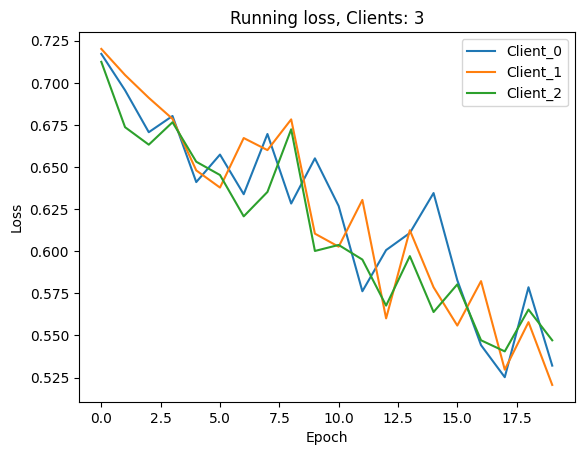

In [ ]:
X = [a for a in range(epochs)]
plot_graph(X, y_s = epoch_losses)

In [ ]:
# X = [a for a in range(epochs)]
# y_s = [[] for _ in range(num_clients)]
# y_s[0] = [0.7 - i*i*0.0005 for i in range(epochs)]
# y_s[1] = [0.7 - i*0.005 for i in range(epochs)]
# plot_graph(X, y_s)

## Save Model

In [ ]:
model_PATH = '/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/' 
model_PATH = model_PATH + "_clients_" + str(num_clients) + "_" + str(train_images) + "_images_" + str(epochs) + "_epochs_"
print(model_PATH)

/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/_clients_3_1000_images_20_epochs_


In [ ]:
for c in range(num_clients):
  torch.save(client_model_list[c].state_dict(), model_PATH+"Client" + str(c) + ".pth")
torch.save(server_model.state_dict(), model_PATH+"Server.pth")

In [ ]:
def model_loader(num_clients, model_PATH):
  client_model_list = [Client(config).to(device) for _ in range(num_clients)]
  for c in range(num_clients):
    mp = model_PATH+"Client" + str(c) + ".pth"
    print(mp)
    client_model_list[c].load_state_dict(torch.load(mp)) 

  return client_model_list

## Evaluation

In [ ]:
def test_accuracy(model_PATH, testloaders):
  tic = time.time()

  client_model_list = model_loader(num_clients, model_PATH)
  server_model = Server(config).to(device) # M
  server_model.load_state_dict(torch.load(model_PATH+"Server.pth"))

  server_model.eval()
  correct = 0
  total = 0

  accuracies = []

  for c in range(num_clients):
    print()
    print("Testing client model ", c)
    client_model_list[c].eval()

    loader = trainloaders[c]

    with torch.no_grad():
      for data in loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = server_model(client_model_list[c](images))

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100*correct/total
    accuracies.append(acc)
    
    print("Accuracy of the client model ", str(c), " is- ", acc, "%")
    print("___________________________________________________________")


  toc = time.time()
  t_test = toc - tic


  return accuracies, t_test

accuracies, t_test = test_accuracy(model_PATH, testloaders)

/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/_clients_3_1000_images_20_epochs_Client0.pth
/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/_clients_3_1000_images_20_epochs_Client1.pth
/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/_clients_3_1000_images_20_epochs_Client2.pth

Testing client model  0
Accuracy of the client model  0  is-  74.0 %
___________________________________________________________

Testing client model  1
Accuracy of the client model  1  is-  62.7 %
___________________________________________________________

Testing client model  2
Accuracy of the client model  2  is-  59.96666666666667 %
___________________________________________________________


In [ ]:
accuracies

[77.5, 80.4, 82.16666666666667]

In [ ]:
accuracies

[77.5, 80.4, 82.16666666666667]

In [ ]:
accuracies

[77.5, 80.4, 82.16666666666667]

## Log

In [ ]:
t_train_test, t_test_test = 10, 10

In [ ]:
# accs_test = [98 for _ in range(num_clients)]

In [ ]:
def condense(lis):
  a = lis[0]
  for b in lis[1:]:
    if b == a:
      continue
    else: return lis
  
  return a

print(condense([51 for _ in range(8)]))
print(condense([4, 6, 4, 4, 4, 4, 4]))


51
[4, 6, 4, 4, 4, 4, 4]


In [ ]:
results = {"Num_Clients":[],	"Train_Images": [],	"Test_Images":[],	"Epochs":[],
        "Test_Accuracy":[], "Train_Time":[],	"Test_Time":[], "Datetime":[], "Running_Losses":[], "Notes":[]}

results["Num_Clients"].append(num_clients)
results["Train_Images"].append(train_images)
results["Test_Images"].append(test_images)
results["Epochs"].append(epochs)
results["Train_Time"].append(t_train)
results["Test_Time"].append(t_test)

results["Datetime"].append(dt)

results["Test_Accuracy"].append(accuracies)
results["Running_Losses"].append(epoch_losses)
# results["Running_Losses"].append(new_epoch_losses)
results["Notes"].append("Different trainloaders (20 epochs), then same trainloaders (5 epochs)")

print(results)
# del_last_update(result_PATH, last_n = 1)
update_results(result_PATH, d_new = results)

{'Num_Clients': [3], 'Train_Images': [1000], 'Test_Images': [200], 'Epochs': [20], 'Test_Accuracy': [[74.0, 62.7, 59.96666666666667]], 'Train_Time': [2265.6007413864136], 'Test_Time': [376.7485144138336], 'Datetime': ['2023-03-31 19:14:57.780864+05:30'], 'Running_Losses': [[[0.7171821165829897, 0.6955732274800539, 0.670679859817028, 0.680316723883152, 0.64106310531497, 0.6573957316577435, 0.6338639929890633, 0.6696153730154037, 0.6283294660970569, 0.6551597639918327, 0.6268745241686702, 0.5762425987049937, 0.6006944607943296, 0.61084502376616, 0.6345586199313402, 0.5827938979491591, 0.5442458158358932, 0.5252182427793741, 0.5786294359713793, 0.5320907607674599], [0.7201260477304459, 0.7046347912400961, 0.6910914294421673, 0.6786049529910088, 0.6480075158178806, 0.6378030255436897, 0.6672180071473122, 0.6600491795688868, 0.6782939862459898, 0.6104455646127462, 0.6027133781462908, 0.6304762177169323, 0.560152567923069, 0.6124900840222836, 0.5786207942292094, 0.5558815095573664, 0.5822645

{'Num_Clients': [4, 4, 1, 2, 2, 6, 6, 6, 3, 3],
 'Train_Images': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
 'Test_Images': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200],
 'Epochs': [20, 5, 20, 20, 20, 20, 20, 20, 20, 20],
 'Test_Accuracy': ['[55.2, 56.25, 56.3, 57.15]',
  '[70.4, 70.35, 70.8, 71.05]',
  '[63.1]',
  '[74.3, 64.35]',
  '[72.7, 75.1]',
  '[90.4, 91.35, 91.36666666666666, 91.45, 91.3, 91.46666666666667]',
  '[90.4, 91.35, 91.36666666666666, 91.45, 91.3, 91.46666666666667]',
  '[89.1, 90.6, 90.33333333333333, 90.775, 90.68, 90.6]',
  '[77.5, 80.4, 82.16666666666667]',
  [74.0, 62.7, 59.96666666666667]],
 'Train_Time': [4135.519359827042,
  697.243905544281,
  676.725418806076,
  1335.1937220096588,
  1335.1937220096588,
  4008.5923953056335,
  4008.5923953056335,
  4008.5923953056335,
  2265.6007413864136,
  2265.6007413864136],
 'Test_Time': [123.5075581073761,
  127.89190530776978,
  32.98576736450195,
  64.26279640197754,
  63.150513648986816,
  